# WALES Lidar

The water vapour differential absorption lidar WALES.
WALES operates at four wave-lengths near 935 nm to measure water-vapor mixing ratio profiles covering the whole atmosphere below the aircraft.
The system also contains additional aerosol channels at 532 nm and 1064 nm with depolarization.  WALES uses a high-spectral resolution technique, which distinguishes molecular from particle backscatter, to make direct extinction measurements. 
At typical flight speeds of 200 m/s the backscatter product from the HSRL has a resolution of 200m in the horizontal and 15m in the vertical, while the water vapor product has approximately 3km horizontal and 250m vertical. The PIs during EUREC4A were Martin Wirth and Heike Gross (DLR).

More information on the instrument can be found in [Wirth et al., 2009](https://elib.dlr.de/58175/). If you have questions or if you would like to use the data for a publication, please don't hesitate to get in contact with the dataset authors as stated in the dataset attributes `contact` or `author`.

*Note: due to safety regulations the Lidar can only be operated above 6 km which leads to data gaps in about the first and last 30 minutes of each flight.*

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import eurec4a

import matplotlib as mpl
mpl.rcParams['font.size'] = 12

## Get data
To load the data we first load the EUREC4A meta data catalog and list the available datasets from WALES. 

More information on the catalog can be found [here](https://github.com/eurec4a/eurec4a-intake#eurec4a-intake-catalogue).

In [3]:
cat = eurec4a.get_intake_catalog()
list(cat.HALO.WALES)

['cloudparameter', 'wv', 'adepg', 'bsri', 'bsrg']

Let's find out what the different variables mean

In [4]:
print(cat.HALO.WALES.cloudparameter.description)
print(cat.HALO.WALES.wv.description)
print(cat.HALO.WALES.adepg.description)
print(cat.HALO.WALES.bsri.description)
print(cat.HALO.WALES.bsrg.description)

WALES-Lidar cloud top height, cloud optical thickness and cloud flag data.
WALES Lidar water wapour volume mixing ratio in ppm
WALES Lidar aerosol depolarisation at 532 nm
WALES Lidar Backscatter Ratio at 1064 nm (parallel polarisation)
WALES Lidar Backscatter Ratio at 532 nm (parallel polarisation)


## Backscatter ratios
Let's first have a look at the backscatter ratios `bsrg` and `bsri` and how they vary over the flight.

We have to specify one flight by it's flight ID and we choose the flight on the 5th of February 2020, `HALO-0205`. The flight IDs and further flight segmentations are introduced later in this notebook. If we pass the information on to dask, we have an [xarray dataset](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html#xarray.Dataset) which provides us with all relevant information from the original netCDF file in form of variables, coordinates, and attributes.

*Note: have a look at the attributes of the xarray dataset `ds` for relevant information on author, contact, or citation.*

In [5]:
ds_bsri = cat.HALO.WALES.bsri["HALO-0205"].to_dask()
ds_bsri

<xarray.Dataset>
Dimensions:                     (range: 698, time: 24240)
Coordinates:
  * time                        (time) datetime64[ns] 2020-02-05T09:34:00.566...
  * range                       (range) float32 0.0 14.99 ... 1.045e+04
Data variables:
    time_resolution             (time) float64 dask.array<chunksize=(24240,), meta=np.ndarray>
    height_above_sea_level      (time) float32 dask.array<chunksize=(24240,), meta=np.ndarray>
    latitude                    (time) float32 dask.array<chunksize=(24240,), meta=np.ndarray>
    longitude                   (time) float32 dask.array<chunksize=(24240,), meta=np.ndarray>
    range_resolution            (time, range) float32 dask.array<chunksize=(24240, 698), meta=np.ndarray>
    emission_wavelength         float32 ...
    instrument_elevation_angle  (time) float32 dask.array<chunksize=(24240,), meta=np.ndarray>
    backscatter_ratio           (time, range) float32 dask.array<chunksize=(24240, 698), meta=np.ndarray>
    sigma_back_r                float32 ...
    temperature                 (time, range) float32 dask.array<chunksize=(24240, 698), meta=np.ndarray>
    rho                         (time, range) float32 dask.array<chunksize=(24240, 698), meta=np.ndarray>
Attributes:
    convention:             CF-1.7
    location_name:          HALO
    platform:               HALO
    instrument:             WALES
    system:                 WALES H2O-DIAL
    title:                  WALES data set
    institution:            Deutsches Zentrum fuer Luft- und Raumfahrt, Insti...
    comment:                EUREC4A measurement, attenuated corrected backsca...
    data_processing_date:   20200807
    data_modified:          20200807
    data_version:           1
    max_altitude:                  10347.716
    min_altitude:                 -100.05273
    max_latitude:                  15.508407
    min_latitude:                  12.300429
    max_longitude:                -53.032715
    min_longitude:                -58.743504
    start_datetime:         2020-02-05T09:34:00
    stop_datetime:          2020-02-05T16:17:59
    mission:                EUREC4A
    ongoing_subset:         10
    detected_polarisation:  parallel

Some tricks:
* The backscatter ratio has a very dynamical range and we have to do some tricks to the colormap range to get a typical Lidar plot. The lines below are copied from [github NARVAL II](https://github.com/narval-ii/common/tree/master/python/narval_ii/plot).
* the `range` coordinate is the distance of the measurement from the aircraft, so we invert the `range` axis in the plot

In [6]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap


WALES_BSR_NORM = LogNorm(vmin=1, vmax=100)
WALES_BSR_TICK_LOCATOR = FixedLocator([
    1, 1.2, 1.4, 1.6, 1.8, 2.0, 4.0, 6.0, 8.0, 10.0, 30.0, 50.0, 70.0, 90.0
])

WALES_BSR = LinearSegmentedColormap.from_list('WALES_BSR', """#cce5ff
    #99ccff #7399ff #4d66ff #264cd9 #0033b3 #005993 #008073 #008c39 #009900 #20a620 #40b340
    #81cd43 #c2e847 #e0f323 #ffff00 #ffef00 #ffe000 #ffc426 #ffa84d #ff8833 #ff691a #f2470d
    #e62600 #d21300 #bf0000 #ac0000 #990000 #4c0000""".split())

Text(0.5, 0, 'time')

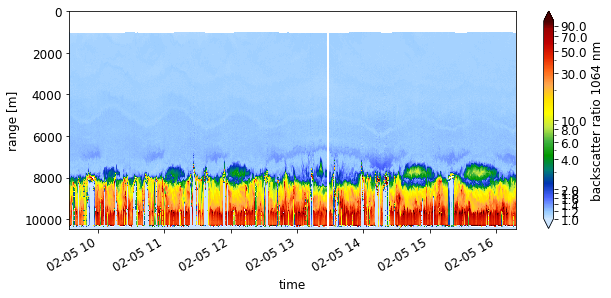

In [7]:
fig, ax = plt.subplots(figsize=(10,4))
ds_bsri.backscatter_ratio.plot.pcolormesh(ax=ax, x="time",
                                         norm=WALES_BSR_NORM, cmap=WALES_BSR,
                                         cbar_kwargs={"format": ScalarFormatter(),
                                                      "ticks": WALES_BSR_TICK_LOCATOR}
                                         )
ax.invert_yaxis()
ax.set_xlabel("time")

You might wonder what the wavey structure is about? The sharp gradient in the variable shows the trade wind inversion layer. The HALO aircraft was flying circles of about 230 km in diameter and sampling the layer at similar locations roughly every hour. The waves hint to an inversion layer that is slightly tilted in the horizontal.

### Defining a height coordinate

Next, we translate the `range` coordinate to a `height` coordinate. The data is already corrected for the aircraft motion (`instrument_elevantion_angle` is constant at 90 degree, looking down), interpolated to a regular height grid and saved relative to a constant height declaration stated in the variable `height_above_sea_level`. We therefore get a `height` coordinate by:
\begin{equation}
height = height\_above\_sea\_level[0] - range
\end{equation}

In [8]:
def add_height_coordinate(ds):
    ds.coords["height"] = ds.height_above_sea_level[0].values - ds.range
    return ds

We plot the backscatter ratio from the green channel `bsrg` with the new height coordinate

In [9]:
ds_bsrg_noheight = cat.HALO.WALES.bsrg["HALO-0205"].to_dask().load()
ds_bsrg = add_height_coordinate(ds_bsrg_noheight)

Text(0.5, 0, 'time')

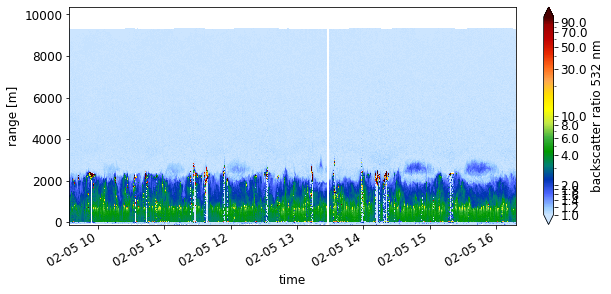

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
ds_bsrg.backscatter_ratio.plot.pcolormesh(ax=ax, x="time", y="height",
                                         norm=WALES_BSR_NORM, cmap=WALES_BSR,
                                         cbar_kwargs={"format": ScalarFormatter(),
                                                      "ticks": WALES_BSR_TICK_LOCATOR}
                                         )
ax.set_xlabel("time")

### HALO flight phase segmentation
For further quicklooks we select a small subset of the flight. All HALO flights were split up into flight phases or segments to allow for a precise selection in time and space of a circle or calibration pattern. For more information have a look at the respective [github repository](https://github.com/eurec4a/halo-flight-phase-separation).

In the following, we select a Lidar calibration leg that was flown on the 5th of February and schow further variables only duing that flight segment.

In [11]:
meta = eurec4a.get_flight_segments()

* get `segment_id` for all Lidar legs on February 5

In [12]:
segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

In [13]:
segments_by_segment_id = {s["segment_id"]: s for s in segments}
segments_ordered_by_start_time = list(sorted(segments, key=lambda s: s["start"]))

In [14]:
lidar_legs = [s["segment_id"]
                 for s in segments_ordered_by_start_time
                 if "lidar_leg" in s["kinds"]
                 and s["start"].date() == datetime.date(2020,2,5)
                 and s["platform_id"] == "HALO"
                ]
lidar_legs

['HALO-0205_ll1']

* extract data for the Lidar leg 1 segment `HALO-0205_ll1`

In [15]:
segments = {s["segment_id"]: {**s, "flight_id": flight["flight_id"]}
             for platform in meta.values()
             for flight in platform.values()
             for s in flight["segments"]
            }
ll1 = segments["HALO-0205_sl1"]

## Water vapor
We read in the water vapor data from that flight and plot the data for the selected segment.

In [16]:
ds_wv_noheight = cat.HALO.WALES.wv["HALO-0205"].to_dask()
ds_wv = add_height_coordinate(ds_wv_noheight)
ds_wv

<xarray.Dataset>
Dimensions:                         (range: 698, time: 2018)
Coordinates:
  * time                            (time) datetime64[ns] 2020-02-05T09:34:12...
  * range                           (range) float32 0.0 14.99 ... 1.045e+04
    height                          (range) float32 1.035e+04 ... -100.1
Data variables:
    time_resolution                 (time) float64 dask.array<chunksize=(2018,), meta=np.ndarray>
    height_above_sea_level          (time) float32 dask.array<chunksize=(2018,), meta=np.ndarray>
    latitude                        (time) float32 dask.array<chunksize=(2018,), meta=np.ndarray>
    longitude                       (time) float32 dask.array<chunksize=(2018,), meta=np.ndarray>
    range_resolution                (time, range) float32 dask.array<chunksize=(2018, 698), meta=np.ndarray>
    emission_wavelength             float32 ...
    instrument_elevation_angle      (time) float32 dask.array<chunksize=(2018,), meta=np.ndarray>
    humidity_mixing_ratio           (time, range) float32 dask.array<chunksize=(2018, 698), meta=np.ndarray>
    error_of_humidity_mixing_ratio  (time, range) float32 dask.array<chunksize=(2018, 698), meta=np.ndarray>
    temperature                     (time, range) float32 dask.array<chunksize=(2018, 698), meta=np.ndarray>
    rho                             (time, range) float32 dask.array<chunksize=(2018, 698), meta=np.ndarray>
Attributes:
    convention:            CF-1.7
    location_name:         HALO
    platform:              HALO
    instrument:            WALES
    system:                WALES H2O-DIAL
    title:                 WALES data set
    institution:           Deutsches Zentrum fuer Luft- und Raumfahrt, Instit...
    comment:               EUREC4A H2O mixing ratio
    data_processing_date:  20200807
    data_modified:         20200807
    data_version:          1
    max_altitude:                 10347.716
    min_altitude:                -100.05366
    max_latitude:                 15.508071
    min_latitude:                 12.300441
    max_longitude:               -53.033249
    min_longitude:               -58.743462
    start_datetime:        2020-02-05T09:34:12
    stop_datetime:         2020-02-05T16:17:36
    mission:               EUREC4A
    ongoing_subset:        10

We only extract the data from the Lidar leg 1, i.e. the flight segment `HALO-0205_ll1` that we defined above

In [17]:
ds_wv_ll1 = ds_wv.sel(time=slice(ll1["start"], ll1["end"]))

Text(0.5, 0, 'time')

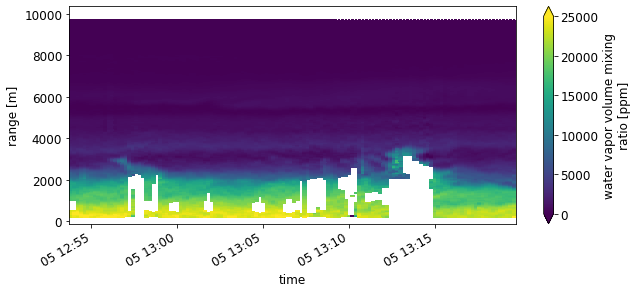

In [18]:
fig, ax = plt.subplots(figsize=(10,4))

ds_wv_ll1.humidity_mixing_ratio.plot.pcolormesh(ax=ax, x="time", y="height",
                                                vmin=0, vmax=25000)
ax.set_xlabel("time")

## Aerosols
We move on to the aerosol product: we want to have a look at the variable `aerosol_depolarisation` and again select only the lidar leg flight segment.

*Note: the air `temperature` and density `rho` in the dataset are extractet from ECMWF and only for internal dataset validation purpose. They are NOT derived from Lidar measurements!*

In [19]:
ds_adepg_noheight = cat.HALO.WALES.adepg["HALO-0205"].to_dask()
ds_adepg = add_height_coordinate(ds_adepg_noheight)
ds_adepg_ll1 = ds_adepg.sel(time=slice(ll1["start"], ll1["end"]))
ds_adepg_ll1

<xarray.Dataset>
Dimensions:                     (range: 698, time: 1557)
Coordinates:
  * time                        (time) datetime64[ns] 2020-02-05T12:53:40.680...
  * range                       (range) float32 0.0 14.99 ... 1.045e+04
    height                      (range) float32 1.035e+04 1.033e+04 ... -100.1
Data variables:
    time_resolution             (time) float64 dask.array<chunksize=(1557,), meta=np.ndarray>
    height_above_sea_level      (time) float32 dask.array<chunksize=(1557,), meta=np.ndarray>
    latitude                    (time) float32 dask.array<chunksize=(1557,), meta=np.ndarray>
    longitude                   (time) float32 dask.array<chunksize=(1557,), meta=np.ndarray>
    range_resolution            (time, range) float32 dask.array<chunksize=(1557, 698), meta=np.ndarray>
    emission_wavelength         float32 ...
    instrument_elevation_angle  (time) float32 dask.array<chunksize=(1557,), meta=np.ndarray>
    aerosol_depolarisation      (time, range) float32 dask.array<chunksize=(1557, 698), meta=np.ndarray>
    temperature                 (time, range) float32 dask.array<chunksize=(1557, 698), meta=np.ndarray>
    rho                         (time, range) float32 dask.array<chunksize=(1557, 698), meta=np.ndarray>
Attributes:
    convention:            CF-1.7
    location_name:         HALO
    platform:              HALO
    instrument:            WALES
    system:                WALES H2O-DIAL
    title:                 WALES data set
    institution:           Deutsches Zentrum fuer Luft- und Raumfahrt, Instit...
    comment:               EUREC4A measurement, particle depolarisation ratio
    data_processing_date:  20200807
    data_modified:         20200807
    data_version:          1
    max_altitude:                 10347.716
    min_altitude:                -100.05273
    max_latitude:                 15.508407
    min_latitude:                 12.300429
    max_longitude:               -53.032715
    min_longitude:               -58.743504
    start_datetime:        2020-02-05T09:34:00
    stop_datetime:         2020-02-05T16:17:59
    mission:               EUREC4A
    ongoing_subset:        10

Text(0.5, 0, 'time')

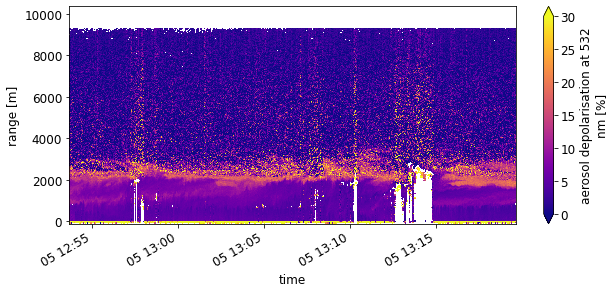

In [20]:
fig, ax = plt.subplots(figsize=(10,4))
ds_adepg_ll1.aerosol_depolarisation.plot.pcolormesh(ax=ax, x="time", y="height",
                                                    vmin=0, vmax=30, cmap="plasma")
ax.set_xlabel("")
ax.set_xlabel("time")

## Cloud parameter

In [21]:
ds_cloud = cat.HALO.WALES.cloudparameter["HALO-0205"].to_dask().load()
ds_cloud

/dev/shm/u237002/anaconda/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'cloud_flag' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,


<xarray.Dataset>
Dimensions:     (time: 121200)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-05T09:34:00.167000064 ... 2020-...
Data variables:
    latitude    (time) float32 13.05 13.05 13.05 13.05 ... 14.29 14.29 14.29
    longitude   (time) float32 -58.69 -58.69 -58.69 ... -57.57 -57.57 -57.57
    cloud_top   (time) float32 1.189e+03 1.017e+03 777.0 ... 1.114e+03 1.122e+03
    cloud_ot    (time) float32 0.1801 nan 0.1265 nan nan ... nan nan nan nan nan
    cloud_flag  (time) float32 1.0 0.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    convention:            CF-1.7
    location_name:         HALO
    platform:              HALO
    instrument:            WALES
    system:                WALES H2O-DIAL
    title:                 WALES data set
    institution:           Deutsches Zentrum fuer Luft- und Raumfahrt, Instit...
    comment:               New version with boundary layer info
    data_processing_date:  20200512
    data_modified:         20200512
    data_version:          1
    max_latitude:                 15.508407
    min_latitude:                 12.300429
    max_longitude:               -53.032715
    min_longitude:               -58.743504
    start_datetime:        2020-02-05T09:34:00
    stop_datetime:         2020-02-05T16:18:01
    mission:               EUREC4A
    ongoing_subset:        10

Some comments:

* The `cloud_flag` values have the meaning 0 - clear and 1 - cloudy. They are defined by a threshold in bsr similar to [Gutleben et al., 2019](https://elib.dlr.de/134038/1/Gutleben_et_al-2019-Geophysical_Research_Letters.pdf) (?)

* The cloud optical thickness `cloud_ot` is derived from the HSRL channel following a standard [HSRL method](http://lidar.ssec.wisc.edu/syst/hsrl/node2.htm) that relates the Lidar signal *S* depending on the distance to the aircraft *r* to the optical thickness *OT* by:
\begin{equation}
OT = -1/2 * ln(S(r)/S(0))
\end{equation}
In clouds with OT greater than about 3.5 the signal to noise ratio is too small meaning that the clouds are intransparent to the Lidar beam, which results in an OT of about 12 in the WALES dataset.

* the cloud or boundary layer top height above sea level `cloud_top` defines a sharp gradient in the backscatter signal. The cloud flag can be used to distinguish between cloud and boundary layer top height.

We select again the Lidar leg segment in `time` and you can use the slice to "zoom" a bit more into the measurements.

In [22]:
ds_cloud_ll1 = ds_cloud.sel(time=slice(datetime.datetime(2020, 2, 5, 13, 6, 30),
                                       datetime.datetime(2020, 2, 5, 13, 7, 30)))

In [23]:
mask_cloud = np.array(ds_cloud_ll1.cloud_flag, dtype=bool)

In [24]:
cloudtop = ds_cloud_ll1.cloud_top.sel(time=np.array(ds_cloud_ll1.cloud_flag, dtype=bool))
BLtop = ds_cloud_ll1.cloud_top.sel(time=np.invert(np.array(ds_cloud_ll1.cloud_flag, dtype=bool)))

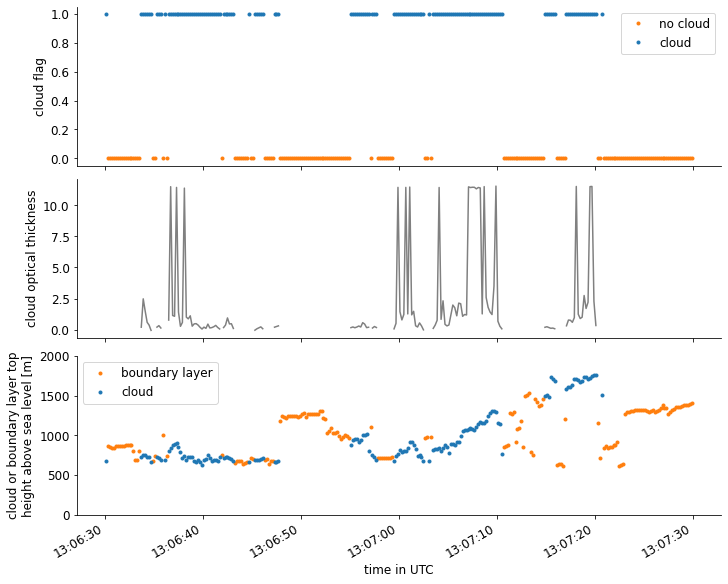

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True,
                                    constrained_layout=True)

ds_cloud_ll1.cloud_flag.sel(time=np.invert(mask_cloud)).plot(ax=ax1, x="time", ls="",
                                                             marker=".", color="C1",
                                                             label="no cloud")
ds_cloud_ll1.cloud_flag.sel(time=mask_cloud).plot(ax=ax1, x="time", ls="", marker=".",
                                                  color="C0", label="cloud")
ax1.set_ylabel(f"{ds_cloud_ll1.cloud_flag.long_name}")
ax1.legend()

ds_cloud_ll1.cloud_ot.plot(ax=ax2, x="time", color="grey")
ax2.set_ylabel(f"{ds_cloud_ll1.cloud_ot.long_name}")

ds_cloud_ll1.cloud_top.sel(time=np.invert(mask_cloud)).plot(ax=ax3, x="time", ls="",
                                                            marker=".", color="C1",
                                                            label="boundary layer")
ds_cloud_ll1.cloud_top.sel(time=mask_cloud).plot(ax=ax3, x="time", ls="", marker=".",
                                                 color="C0", label="cloud")
ax3.set_ylim(0, 2000)
ax3.set_ylabel("cloud or boundary layer top\nheight above sea level [m]")
ax3.legend()

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('time in UTC')
for ax in [ax1, ax2, ax3]:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

### Cloud fraction

In [26]:
cf = np.sum(ds_cloud.cloud_flag.values==1) / ds_cloud.cloud_flag.size
cf_ot_gt_3 = np.sum(ds_cloud.cloud_ot.values > 3) / ds_cloud.cloud_flag.size
print(f"Total cloud fraction on Feb 5: {cf*100:.2f} %")
print(f"Fraction of clouds with optical thickness greater than 3: {cf_ot_gt_3*100:.2f} %")

Total cloud fraction on Feb 5: 39.92 %
Fraction of clouds with optical thickness greater than 3: 11.31 %


We can use a time averaging window to derive a cloud fraction from the `cloud_flag` variable and see how it varies over the course of the flight.

In [27]:
def fraction_from_flag(ds, timedelta):
    return ds.groupby_bins(group=ds.time,
                           bins=np.arange(ds.time.values[0],
                                          ds.time.values[-1],
                                          np.timedelta64(timedelta, "m"))
                          ).mean()

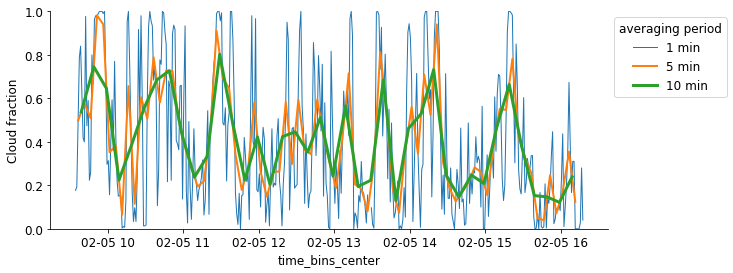

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))

for ind, t in enumerate([1, 5, 10]):
    fraction_from_flag(ds_cloud.cloud_flag, t).plot(lw=ind + 1, label=f"{t} min")

ax.set_ylim(0, 1)
ax.set_ylabel("Cloud fraction")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(title="averaging period", bbox_to_anchor=(1,1), loc="upper left")